In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [3]:
apps = pd.read_csv('../input_data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('../input_data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('../input_data/jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines="skip")
users = pd.read_csv('../input_data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('../input_data/test_users.tsv', delimiter='\t',encoding='utf-8')

FileNotFoundError: [Errno 2] No such file or directory: '../input_data/apps.tsv'

**Pre-process**

There are 3 files which we require to split into training and test sets -
1. apps
2. user_history
3. users

In [10]:
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']

In [9]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [11]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']

users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [12]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [30]:
import re

removePattern = r'(<(.*?)>)|(&\w+)'
addSpacePattern = r'([;:])|(\\r)|(\\n)'
removeExtraSpaces = r'(\s\s+?)(?=\S)'

jobs['DescCleaned'] = jobs['Description'].astype(str).str.lower()
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))
# Similarly for requirements
jobs['ReqCleaned'] = jobs['Requirements'].astype(str).str.lower()
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))


In [101]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


In [102]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [103]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', 
                                                                                    ascending=False)

/var/folders/cj/qfrhvmb90676tpsym70kql640000gn/T/ipykernel_7176/609907941.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


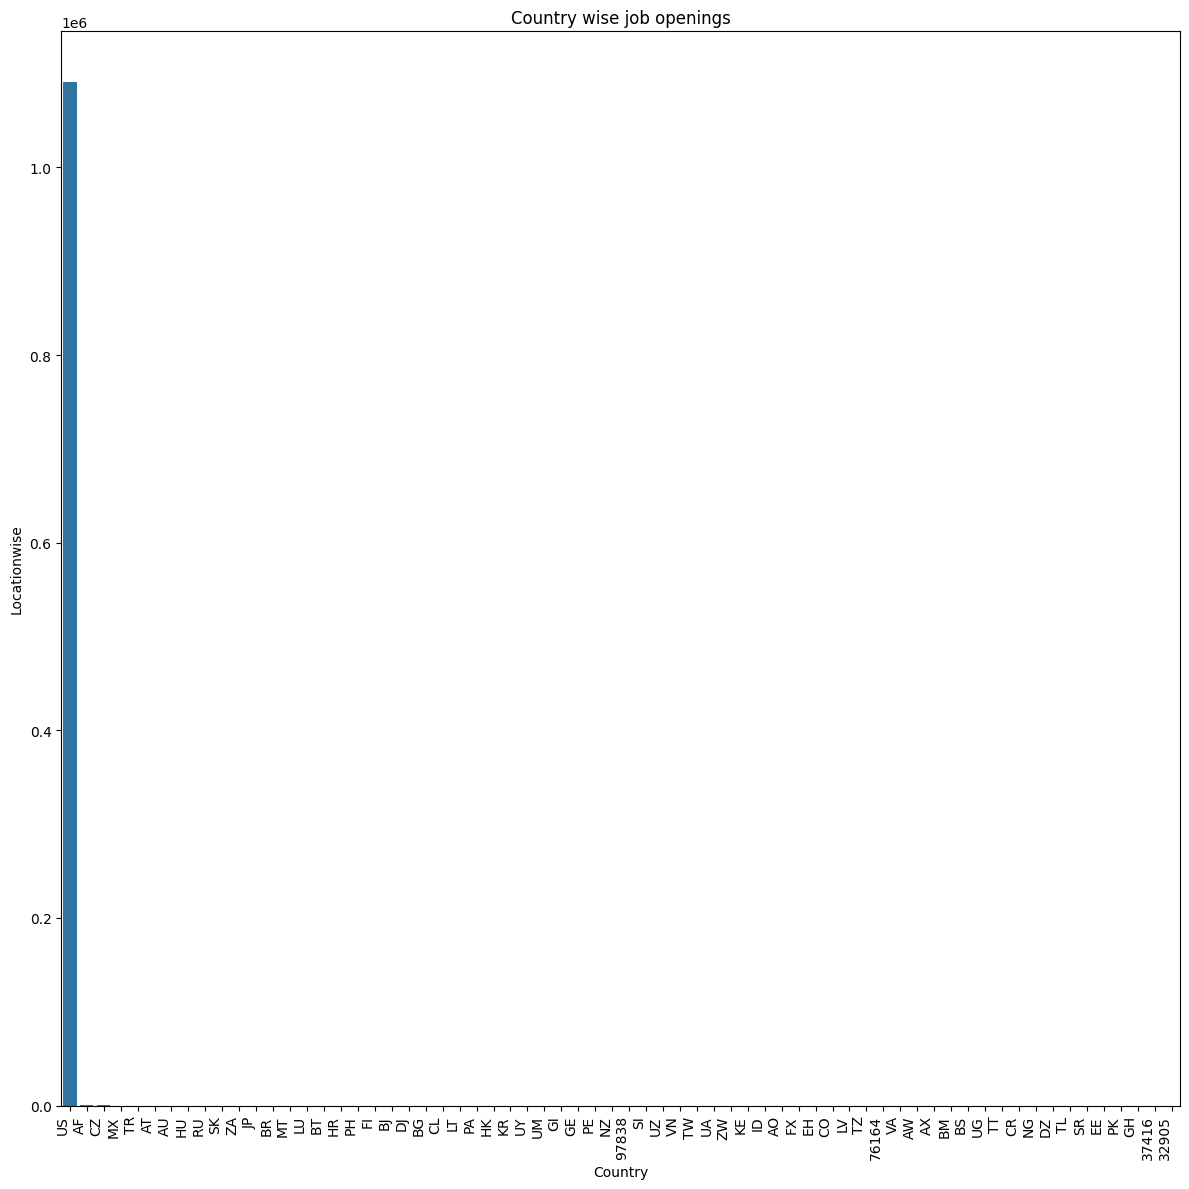

In [104]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

As we can see above, almost all of the jobs are present in the united states. 
Thus, we will only consider jobs in the United States and remove any noise in the dataset. <br>
In below, I will be doing 3 things ->

1. I will remove the city column as it is not really very important and has a lot of noise
2. I will remove the data points which have state as NULL or as numbers
3. I will be considering only US as the country         

In [105]:
jobs = jobs.loc[jobs['Country']=='US']
jobs.drop(columns=['City'])

,JobID,WindowID,Title,Description,Requirements,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59
...,...,...,...,...,...,...,...,...,...,...
1091918,1116242,7,ELECTRICAL SPECIALIST,"<p><strong><span style=""text-decoration: under...",<ul>\r <li>3-5 years experience as a plant ...,NY,US,12010,2012-06-12 15:18:25.133,2012-07-11 23:59:00
1091919,1116253,7,General and Assistant Managers,"<div style=""text-align: center""><span style=""t...",<ul>\r <li>5-8 years of <em>Restaurant Mana...,AL,US,NaN,2012-05-29 15:57:34.067,2012-06-28 23:59:00
1091920,1116294,7,Assistant Retail Store Manager - Retail Sales ...,"<span>\r<hr>\r<p align=""center""><strong>Assist...","<span>\r<hr>\r<p align=""center""><strong>Assist...",MS,US,39051,2012-05-25 12:20:17.28,2012-06-24 23:59:00
1091921,1116304,7,Career Experience Specialist - Career Services...,<p>&nbsp;</p>\r<p><b><span>Macomb Community Co...,see description,MI,US,48088,2012-05-24 12:34:38.667,2012-06-23 23:59:00


In [107]:
job_distribution = apps['JobID'].value_counts()
user_distribution = apps['UserID'].value_counts()

top_jobs = job_distribution.head(7000).index

top_users = user_distribution.head(7000).index

filtered_apps = apps[(apps['JobID'].isin(top_jobs)) & (apps['UserID'].isin(top_users))]

print("New size of filtered apps DataFrame:", len(filtered_apps))

New size of filtered apps DataFrame: 103565


In [108]:
filtered_user_ids = filtered_apps['UserID'].unique()
filtered_job_ids = filtered_apps['JobID'].unique()

filtered_users = users[users['UserID'].isin(filtered_user_ids)]
filtered_jobs = jobs[jobs['JobID'].isin(filtered_job_ids)]

print("New size of filtered users DataFrame:", len(filtered_users))
print("New size of filtered jobs DataFrame:", len(filtered_jobs))

New size of filtered users DataFrame: 6223
New size of filtered jobs DataFrame: 6971


In [109]:
# function to calculate sparsity given number of items, number of users, and number of ratings
def sparsity(num_items, num_users, num_ratings):
  return (num_items * num_users - num_ratings) / (num_users * num_items)


sparsity(len(filtered_apps), len(filtered_users), len(filtered_jobs))

0.999989183611637

In [ ]:
# Save filtered jobs DataFrame to CSV
filtered_jobs.to_csv('filtered_jobs.csv', index=False)

# Save filtered apps DataFrame to CSV
filtered_apps.to_csv('filtered_apps.csv', index=False)

# Save filtered users DataFrame to CSV
filtered_users.to_csv('filtered_users.csv', index=False)

In [19]:
apps = pd.read_csv('filtered_apps.csv')
users = pd.read_csv('filtered_users.csv')
jobs = pd.read_csv('filtered_jobs.csv')

**NOW, WE WILL BUILD THE USER-ITEM INTERACTION MATRIX**

This is needed for any collaborative filtering or Matrix Factorization that we intend to do

In [31]:
# First, generate dictionaries for mapping old id to new id for users and movies
unique_JobID = apps['JobID'].unique()
unique_UserID = apps['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
job_old2new_id_dict = dict()
for i in unique_JobID:
    job_old2new_id_dict[i] = j
    j += 1


# Then, use the generated dictionaries to reindex UserID and JobID in the data_df
user_list = apps['UserID'].values
job_list = apps['JobID'].values
for j in range(len(apps)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    job_list[j] = job_old2new_id_dict[job_list[j]]
apps['UserID'] = user_list
apps['JobID'] = job_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(apps)) <= 0.7
train_df = apps[train_index]
test_df = apps[~train_index]

In [32]:
train_df['Applied?'] = 1
test_df['Applied?'] = 1

/var/folders/cj/qfrhvmb90676tpsym70kql640000gn/T/ipykernel_10014/1562490702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Applied?'] = 1
/var/folders/cj/qfrhvmb90676tpsym70kql640000gn/T/ipykernel_10014/1562490702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Applied?'] = 1


In [33]:
from scipy.sparse import coo_matrix

# generate train_mat and test_mat
num_users = len(apps['UserID'].unique())
num_jobs = len(apps['JobID'].unique())

train_mat = coo_matrix((train_df['Applied?'].values, (train_df['UserID'].values, train_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()
test_mat = coo_matrix((test_df['Applied?'].values, (test_df['UserID'].values, test_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()

In [28]:
train_mat.shape

(6223, 6971)

In [29]:
test_mat.shape

(6223, 6971)

In [30]:
train_mat.shape

(6223, 6971)

**EVALUATION CRITERIA**

Now, that we have user-item interaction matrix, I define the evaluation as follows ->

1. If the user i has applied to job j, then train_mat[i, j] = 1, else it is 0.
2. I will train my Collaborative filtering models, MF models, etc. on the train_mat and find out the probability that user i applies for job j for each user, job pair. 
3. Then, I will use the test_mat. For every job that the user has applied to in the test_mat, the error is 1 - prob_from_my_model. This way, I can train any model.
<br>
<br>


This, is essentially an implementation of Bayesian Personalized Ranking which was taught in class

In [34]:
import pickle

with open('train_mat.pkl', 'wb') as file:
    pickle.dump(train_mat, file)

with open('test_mat.pkl', 'wb') as file:
    pickle.dump(test_mat, file)